# Analisis dan Klasifikasi Prestasi Siswa Berdasarkan Parenting
Notebook ini melakukan:
- Pembersihan dan pra-pemrosesan data
- Pelatihan model Random Forest
- Evaluasi model
- Tuning hyperparameter
- Prediksi data baru
- Visualisasi ROC untuk klasifikasi multi-kelas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('../data/parenting_prestasi.csv')
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


## Pembersihan dan Pra-pemrosesan Data
Langkah ini mencakup:
- Penanganan nilai hilang
- Penghapusan duplikasi
- Standarisasi kapitalisasi
- Rekayasa fitur TotalEngagement

In [3]:
num_cols = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
cat_cols = ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 
            'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 
            'ParentschoolSatisfaction', 'StudentAbsenceDays']

for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

df.drop_duplicates(inplace=True)
df['gender'] = df['gender'].str.upper()
df['NationalITy'] = df['NationalITy'].str.title()
df['PlaceofBirth'] = df['PlaceofBirth'].str.title()
df['ParentAnsweringSurvey'] = df['ParentAnsweringSurvey'].str.title()
df['ParentschoolSatisfaction'] = df['ParentschoolSatisfaction'].str.title()
df['TotalEngagement'] = df['raisedhands'] + df['VisITedResources'] + df['AnnouncementsView'] + df['Discussion']

## Encoding Variabel Kategorikal dan Target

In [4]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

le_class = LabelEncoder()
df['Class'] = le_class.fit_transform(df['Class'])

## Pembagian Data untuk Pelatihan dan Pengujian

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing Pipeline

In [6]:
numeric_features = num_cols + ['TotalEngagement']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, cat_cols)])

## Pelatihan Model dan Evaluasi Awal

In [7]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean():.2f}")

Cross-validation scores: [0.61458333 0.66666667 0.75       0.70526316 0.72631579]
Average CV score: 0.69


## Hyperparameter Tuning dengan GridSearchCV

In [8]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}


## Evaluasi Model Terbaik

In [9]:
y_pred = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=le_class.classes_))

Accuracy: 0.83
              precision    recall  f1-score   support

           H       0.77      0.83      0.80        24
           L       0.86      0.93      0.89        27
           M       0.85      0.78      0.81        45

    accuracy                           0.83        96
   macro avg       0.83      0.85      0.84        96
weighted avg       0.83      0.83      0.83        96



## Prediksi Data Baru

In [10]:
def handle_unseen_labels(value, le):
    if value not in le.classes_:
        return 'Unknown'
    return value

def preprocess_new_data(new_data):
    new_data = new_data.copy()
    new_data['gender'] = new_data['gender'].str.upper()
    new_data['NationalITy'] = new_data['NationalITy'].str.title()
    new_data['PlaceofBirth'] = new_data['PlaceofBirth'].str.title()
    new_data['ParentAnsweringSurvey'] = new_data['ParentAnsweringSurvey'].str.title()
    new_data['ParentschoolSatisfaction'] = new_data['ParentschoolSatisfaction'].str.title()
    new_data['TotalEngagement'] = (new_data['raisedhands'] + new_data['VisITedResources'] + 
                                   new_data['AnnouncementsView'] + new_data['Discussion'])
    for col in cat_cols:
        le = label_encoders[col]
        new_data[col] = new_data[col].apply(lambda x: handle_unseen_labels(x, le))
        new_data[col] = le.transform(new_data[col])
    return new_data

new_data = pd.DataFrame({
    'gender': ['M'],
    'NationalITy': ['KW'],
    'PlaceofBirth': ['KuwaIT'],
    'StageID': ['MiddleSchool'],
    'GradeID': ['G-07'],
    'SectionID': ['A'],
    'Topic': ['IT'],
    'Semester': ['F'],
    'Relation': ['Father'],
    'raisedhands': [50],
    'VisITedResources': [60],
    'AnnouncementsView': [30],
    'Discussion': [70],
    'ParentAnsweringSurvey': ['Yes'],
    'ParentschoolSatisfaction': ['Good'],
    'StudentAbsenceDays': ['Under-7']
})
prediction = best_model.predict(preprocess_new_data(new_data))
print(f"Predicted class: {le_class.inverse_transform(prediction)[0]}")

Predicted class: M


## Simpan Dataset yang Telah Dibersihkan dan Dikodekan

In [11]:
df_cleaned = df.copy()
df_cleaned.to_csv('../data eval/parenting_prestasi_cleaned.csv', index=False)
print("Dataset telah disimpan sebagai 'parenting_prestasi_cleaned.csv'")

Dataset telah disimpan sebagai 'parenting_prestasi_cleaned.csv'


## Visualisasi ROC Curve untuk Klasifikasi Multi-Kelas

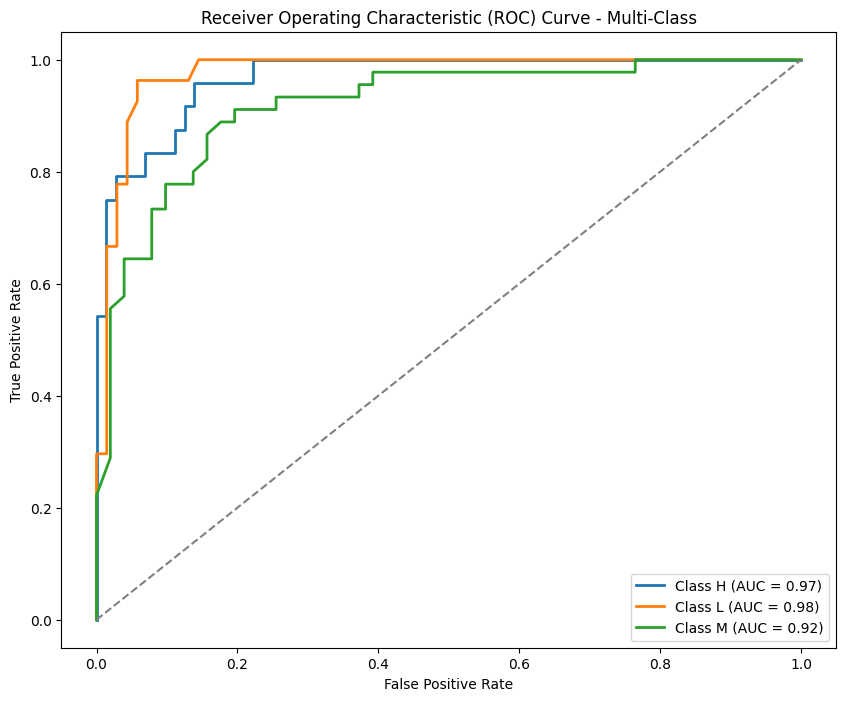

In [12]:
y_test_binarized = label_binarize(y_test, classes=np.arange(len(le_class.classes_)))
y_score = best_model.predict_proba(X_test)
plt.figure(figsize=(10, 8))
for i in range(len(le_class.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {le_class.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()